# ENSAE NLP Project 2024 - Predicting the Sex in French Archive Census Data

In [3]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [4]:
DATA = '../data'

## Import data

In [5]:
# Load data.
name_sex_freq_df = pd.read_csv(f"{DATA}/firstname_with_sex.csv", sep=';')
sex_transcription_df = pd.read_csv(f"{DATA}/transcriptions_with_sex.csv")

# Print data shapes.
print("Name frequency shape:", name_sex_freq_df.shape)
print("Transcription shape:", sex_transcription_df.shape)

# Compute total frequency of each name.
name_sex_freq_df = name_sex_freq_df.assign(count=name_sex_freq_df["male"] + name_sex_freq_df["female"]) 

# Compute conditional likelihood to be female given the firstname.
name_sex_freq_df["male_likelihood"] = name_sex_freq_df["male"] / name_sex_freq_df["count"]
name_male_lk_df = name_sex_freq_df[["firstname", "count", "male_likelihood"]]
name_sex_freq_df.head()

Name frequency shape: (6946, 3)
Transcription shape: (241, 4)


,firstname,male,female,count,male_likelihood
0,marie,10145,2390322,2400467,0.004226
1,jean,1869615,6476,1876091,0.996548
2,pierre,1475841,5047,1480888,0.996592
3,jeanne,1765,1097397,1099162,0.001606
4,françois,1089009,5951,1094960,0.994565


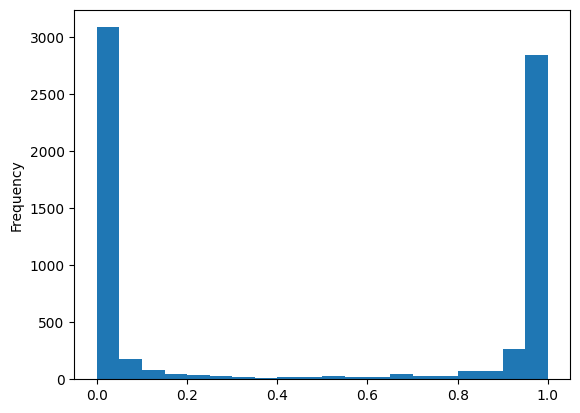

In [67]:
# Male Frequency per First Name.
name_male_lk_df["male_likelihood"].plot(kind='hist', bins=20);

## Data Cleaning

### Extract groundtruth information in tabular format

In [7]:
# Display entirely the cells contents.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [8]:
# Observing the data (transcriptions).
sex_transcription_df.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: idem link: fille age: 30,"nom: Chardon prénom: Marie date_naissance: 30 lieux_naissance: """,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupation: sp link: chef age: 67,nom: Lhopital prénom: Louis Jean date_naissance: 67 lieux_naissance: Sn employeur: ahef,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: idem link: idem employer: idem age: 15,nom: Pyrin prénom: Marie date_naissance: 55 relation: d,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny,nom: Lavocat prénom: Marie date_naissance: 1875 lieux_naissance: Rigny profession: '',femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: 78 lieux_naissance: id relation: '',femme


In [9]:
# Check some observation
sex_transcription_df["groundtruth"][0:5]

0                surname: Chardon firstname: Marie occupation: idem link: fille age: 30 
1             surname: Lhopital firstname: Louis-Jean occupation: sp link: chef age: 67 
2    surname: Papin firstname: Marie occupation: idem link: idem employer: idem age: 15 
3             surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny 
4                                          surname: Benne firstname: Marguerite age: 78 
Name: groundtruth, dtype: object

In [10]:
# Extract the transcription into a dictionary.
# pattern = r'(\w+): (\w+(-\w+)?)'
pattern = r'(\w+): ([^:]+?)(?=\s+\w+:|$)'

def extract_dict(string, pattern):
    matches = re.findall(pattern, string)
    return dict(matches)

sex_transcription_df['groundtruth_dict'] = (
    sex_transcription_df['groundtruth'].apply(extract_dict, pattern=pattern)
)
sex_transcription_df['predicted_dict'] = (
    sex_transcription_df['prediction'].apply(extract_dict, pattern=pattern)
)

In [11]:
# Normalize the dictionary into a dataframe.
groundtruth_df = pd.json_normalize(
    sex_transcription_df['groundtruth_dict']
).add_suffix('_gt')
# predicted_df = pd.json_normalize(
#     sex_transcription_df['predicted_dict']
# ).add_suffix('_pred')

# Concatenate the groundtruth dataframe with the transcription dataframe.
sex_gt_df = (
    pd.concat(
        [sex_transcription_df, groundtruth_df], axis=1)
    .drop(columns=['groundtruth_dict', 'predicted_dict', 'groundtruth', 'prediction', 'subject_line'])
)
# Normalize columns.
sex_gt_df = sex_gt_df.map(lambda x: x.title() if isinstance(x, str) else x)
sex_gt_df.head()


,sex,surname_gt,firstname_gt,occupation_gt,link_gt,age_gt,employer_gt,birth_date_gt,lob_gt,civil_status_gt,observation_gt
0,Femme,Chardon,Marie,Idem,Fille,30,NaN,NaN,NaN,NaN,NaN
1,Homme,Lhopital,Louis-Jean,Sp,Chef,67,NaN,NaN,NaN,NaN,NaN
2,Femme,Papin,Marie,Idem,Idem,15,Idem,NaN,NaN,NaN,NaN
3,Femme,Lavocat,Marie,NaN,Femme,NaN,NaN,1875,Rigny,NaN,NaN
4,Femme,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN


In [12]:
# Hyphenated (compound) names.
sex_gt_df[sex_gt_df['firstname_gt'].str.contains('-', na=False)]

,sex,surname_gt,firstname_gt,occupation_gt,link_gt,age_gt,employer_gt,birth_date_gt,lob_gt,civil_status_gt,observation_gt
1,Homme,Lhopital,Louis-Jean,Sp,Chef,67,NaN,NaN,NaN,NaN,NaN
62,Homme,Daviot,Jean-Marie,Domestique De Ferme,Domestique De Ferme,25,NaN,NaN,NaN,NaN,NaN
102,Homme,Vichard,Jean-Marie,Idem,Fils,5,NaN,NaN,NaN,NaN,NaN
205,Homme,Foury,Jean-Baptiste,Tourneur,Chef,26,Chemin De Fer,NaN,NaN,NaN,NaN
211,Homme,Thély,Jean-Claude,Idem,Idem,NaN,Idem,1892,Coulanges,NaN,NaN
229,Femme,Ribet,Marie-Louise,Idem,Fille,5,NaN,NaN,NaN,NaN,NaN


In [13]:
# Split hyphenated first names.
sex_gt_df[['firstname1_gt', 'firstname2_gt']] = sex_gt_df['firstname_gt'].str.split("-", expand=True)
sex_gt_df.head(10)

,sex,surname_gt,firstname_gt,occupation_gt,link_gt,age_gt,employer_gt,birth_date_gt,lob_gt,civil_status_gt,observation_gt,firstname1_gt,firstname2_gt
0,Femme,Chardon,Marie,Idem,Fille,30,NaN,NaN,NaN,NaN,NaN,Marie,None
1,Homme,Lhopital,Louis-Jean,Sp,Chef,67,NaN,NaN,NaN,NaN,NaN,Louis,Jean
2,Femme,Papin,Marie,Idem,Idem,15,Idem,NaN,NaN,NaN,NaN,Marie,None
3,Femme,Lavocat,Marie,NaN,Femme,NaN,NaN,1875,Rigny,NaN,NaN,Marie,None
4,Femme,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN,Marguerite,None
5,Homme,Roy,Antoine,Métayer Patron,Chef De Ménage,51 Ans,NaN,NaN,NaN,NaN,NaN,Antoine,None
6,Homme,Bizet,Louis,NaN,Idem,9,NaN,NaN,NaN,NaN,NaN,Louis,None
7,Homme,Garitat,Jules,NaN,Fils,12,NaN,NaN,NaN,NaN,NaN,Jules,None
8,Femme,Souche,Maria,Idem,Idem,4 Mois,NaN,NaN,NaN,NaN,NaN,Maria,None
9,Femme,Guichou,Elisabeth,Néant,Femme,28,NaN,NaN,NaN,NaN,NaN,Elisabeth,None


### Columns normalization and cleansing

* [ ] Binarize label (Homme=1, Femme=0)
* [ ] Merge transcription with frequency dataframe based on "firstname1"
```SQL
SELECT s.*
FROM sex_gt as s
    LEFT JOIN name_male_lk as n
    ON s.gt_firstname1 AND n.firstname
```
* [ ] `occupation`: abbreviation, "idem" values (probably meaning use previous information from the same household) [link with household chief prediction task]
* [ ] `link`: "idem" values
* [ ] `birth_date` and `age`: do we know the date of collection?
* [ ] `lob` -> `birth_place`

* **Missing values**: *civil status* (98%), *birth place (lob)* (80%) and *employer* (80%) columns have a high missing values rates. As for the relevance of these variables in predicting an individual's sex, it's not straightforward:

  * **Civil Status**: This might have some relevance, as certain civil statuses might be more common among certain genders due to societal norms or historical trends. However, with 98% data missing, it's unlikely to be a reliable predictor.

  * **Birth Place (lob)**: This is unlikely to be a strong predictor of sex, as birth place is not typically associated with one's sex. However, if there are certain locations with skewed gender ratios, it might provide some predictive power. We don't believe (in a Bayesian sense) that birthplace alone can predict sex, except perhaps in very rare instances that would have been evident in a cross-tabulation of the two variables or through external data or prior studies. However, when birthplace is combined with the first name, it could reveal additional patterns in certain regions. For example, a name traditionally given to males might be more commonly assigned to females in a particular area. If we have sufficient data or can access such data, we could analyze the frequency of first names by sex and birthplace.

  * **Employer**: This could potentially be relevant, as certain industries or occupations have historically been dominated by one sex. However, with 80% data missing, its usefulness as a predictor is questionable. There may be patterns where a company predominantly employs men or women, but this could also be associated with the type of occupation, a field for which we have a high completion rate.

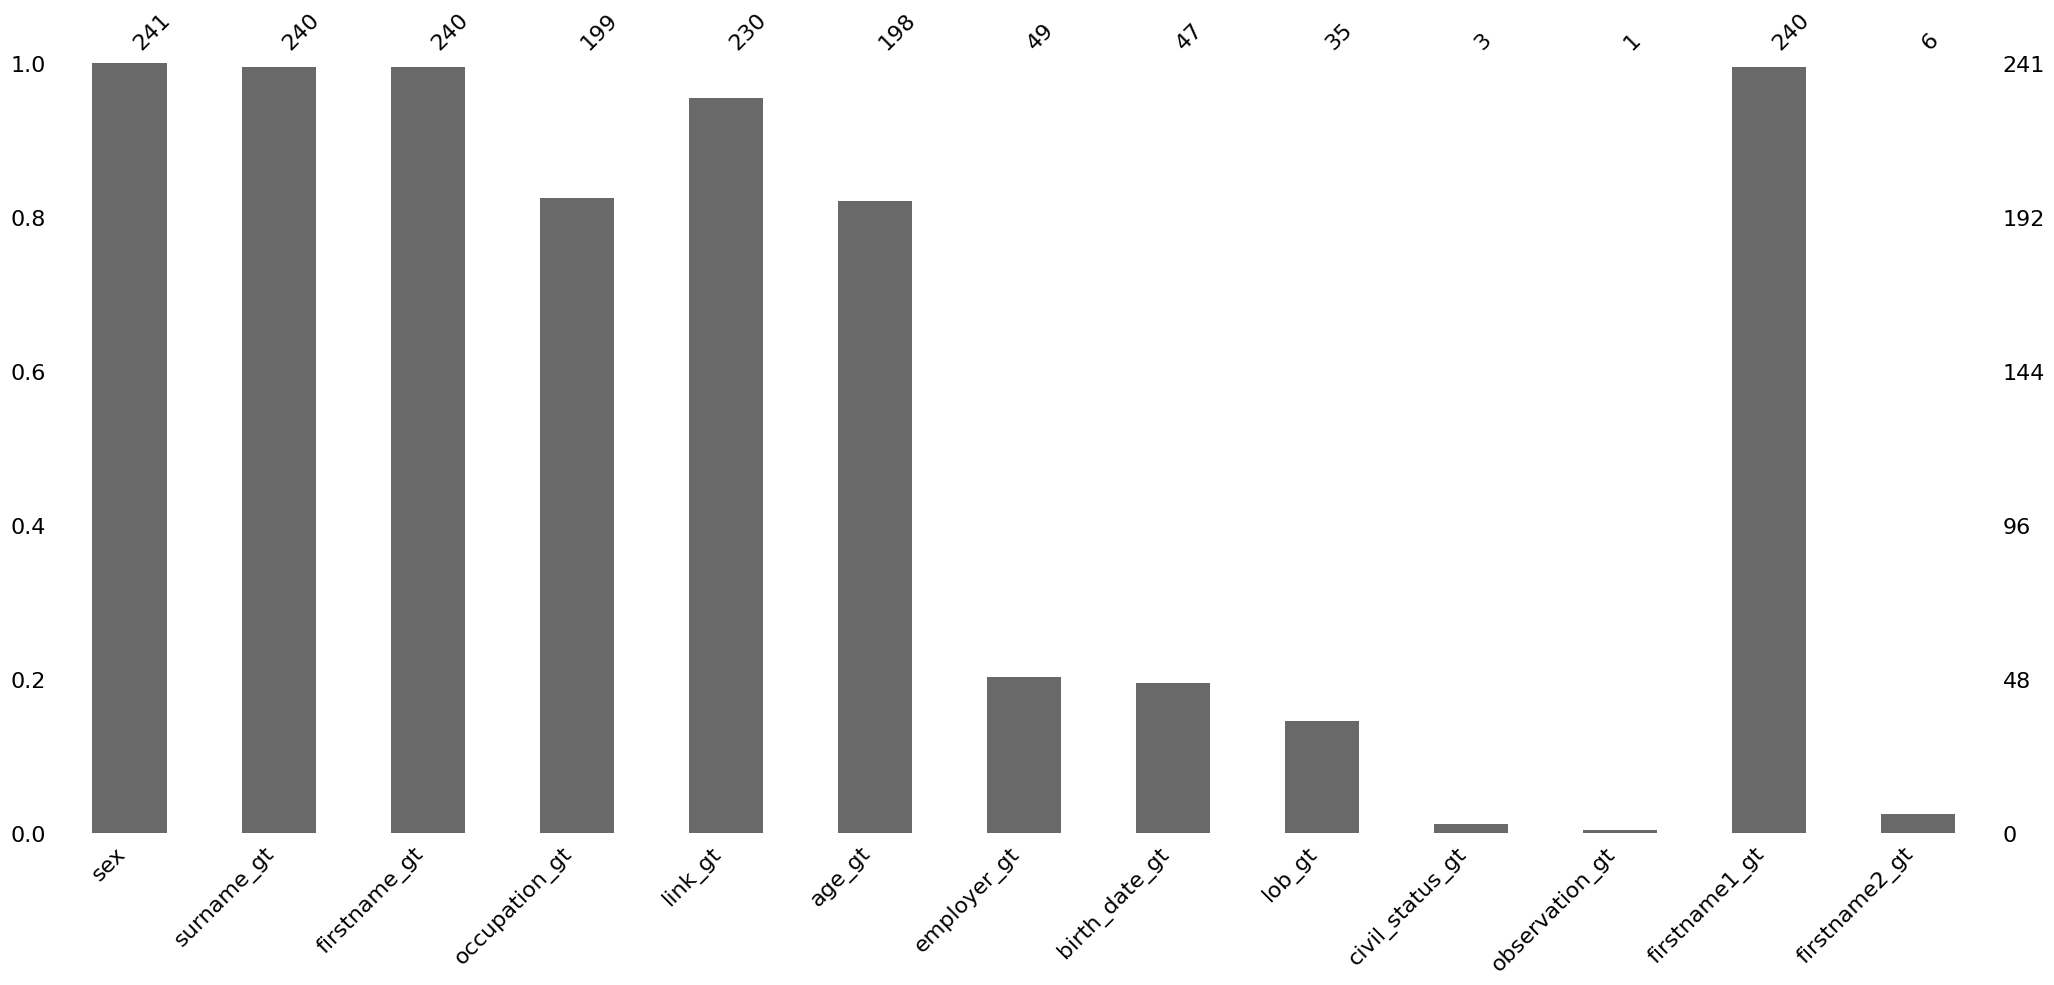

In [14]:
# Missing values.
# msno.matrix(sex_gt_df);
msno.bar(sex_gt_df);

* **Sex**: There is an "Ambigu" category that is problematic. Should we consider it as a category per se ? On one side, yes as It could represent a distinct group within the data that has unique characteristics. Ignoring it could lead to loss of valuable information. It respects the original data and does not involve any assumptions or imputations. But as this category is not well-defined or understood, it could introduce noise or confusion into the analysis. Furthermore, if we consider that the category is small (4%) it may not have a significant impact on the overall analysis, but could still complicate the interpretation of results. The "Ambigu" category under 'Sex' is evidently not a pertinent category, as it stems from uncertainties during data collection. We will include it in our descriptive statistics for completeness, but it will not be factored into the predictive model. Initially, we will exclude these observations from the model building process. After training the model on the remaining data, we can then use it to make predictions for these "Ambigu" observations. Or we can impute this observation by the most common category conditional to the firstname.

In [15]:
sex_gt_df["sex"].value_counts(dropna=False)

sex
Homme     125
Femme     107
Ambigu      9
Name: count, dtype: int64

In [16]:
sex_gt_df[sex_gt_df['sex'] == "Ambigu"]

,sex,surname_gt,firstname_gt,occupation_gt,link_gt,age_gt,employer_gt,birth_date_gt,lob_gt,civil_status_gt,observation_gt,firstname1_gt,firstname2_gt
17,Ambigu,Daniel,Claude,Journalier,Chef,33,NaN,NaN,NaN,NaN,NaN,Claude,None
59,Ambigu,Gorbinet,Jeanne,Idem,Chef,66,NaN,NaN,NaN,NaN,NaN,Jeanne,None
94,Ambigu,Roumeau,Claude,Cultivateur,Chef,30 Ans,NaN,NaN,NaN,NaN,NaN,Claude,None
123,Ambigu,Chardon,Marie,Idem,Chef,84 Ans,NaN,NaN,NaN,NaN,NaN,Marie,None
124,Ambigu,Grillé,Emile,Idem,Idem,2,Idem,NaN,NaN,NaN,NaN,Emile,None
130,Ambigu,Martin,Marie,Idem,Idem,45,NaN,NaN,NaN,NaN,NaN,Marie,None
196,Ambigu,Pénot,Claude,S.P,Enfant,13,NaN,NaN,NaN,NaN,NaN,Claude,None
204,Ambigu,Coq,Antonie,Idem,Idem,16,Idem,NaN,NaN,NaN,NaN,Antonie,None
230,Ambigu,Clayeux,Claude,Idem,Idem,13,Idem,NaN,NaN,NaN,NaN,Claude,None


- **Occupation**: The primary challenge with this variable lies in the inconsistency of spelling within the same category across different observations. 

Normalizing these values could be beneficial. One approach is to employ a function based on manual inspection, such as "brute-force" mapping, regular expressions, or semi-automatic (yet deterministic) distance-based fuzzy matching (possibly preceed or followed by lemmatization to get rid of gender declination). This ensures complete control over the processing step and is perhaps the most commonly used and straightforward method. However, it necessitates knowledge of the specifics of the data collection context. Additionally, these approaches can be time-consuming and labor-intensive, particularly when dealing with a wide range of categories. 

Another option is to utilize pre-trained foundational models to infer the category and aid in normalization. This approach enables leveraging morphological similarities (varied spelling) or contextual patterns (e.g., abbreviations) to standardize the categories or identify clusters of values referring to the same occupation. Using Language Model (LLM)-based inference offers scalability and adaptability to new data and variations in occupations.

Furthermore, the presence of "idem" values implies that the corresponding entries are identical to those in preceding observations. Given that individuals were interviewed within households, each household is typically headed by one individual, whose information is recorded first, followed by other household members. "Idem" indicates that the current entry matches the category of the previously recorded member. However, this assumption hinges on the ordering of the samples, which may not always be reliable. We can notice that it is linked to the second task of head of household prediction in the sense that knowing the head would help to correct this values.

In [17]:
sex_gt_df["occupation_gt"].unique()

array(['Idem', 'Sp', nan, 'Métayer Patron', 'Néant', 'Journalier',
       'Cantonnier', 'Cultivateur', 'Sans Prof', 'Domestique', 'Couvreur',
       'Roulier', 'S.P', 'Garde Part.', 'Journalière', 'Manoeuvre',
       'Forgeron', 'Ouvrier', 'Propriétaire', 'Sans Profession',
       'Argentière', 'Voiturier', 'S.P.', 'Jardinier',
       'Domestique De Ferme', 'Cult Eur Fermier', 'Métayer',
       'Cultivateur Fermier', 'Femme De Chambre', 'Sans Prof.',
       'Garde-Champêtre', 'Culivateur', 'Cult Eur', 'Boulanger',
       'Buraliste', 'Sans P.', 'Clerc De Nptaire', 'Quincaillier',
       'Charcutier', 'Sellier', 'Sans P', 'Imprimeur', 'Patissier',
       'Cullotière', 'Employé', 'Blanchiseuse', 'S P', 'Nourrisson',
       'Journalier Terrassier', 'Cultivatrice', 'Cultivat', 'Charretier',
       'Rentière', 'Repasseuse', 'Receveur Enregistrement',
       'Garde Particulier', 'Ouvrier Meunier', 'Domest.', 'Menuisier',
       'Tourneur', 'Agent De Police', 'Couturière', 'Déposit De Journau

In [18]:
import re
import numpy as np

def normalize_occupation(occupation):
    # Remove punctuation and extra spaces
    occupation = re.sub(r'[.]', '', occupation)  # Remove punctuation
    occupation = re.sub(r'\s+', ' ', occupation).strip()  # Remove extra spaces and strip leading/trailing spaces

    # Define mapping using regular expressions
    occupation_mappings = {
        r'\bs(?:ans|\s|\.)p(?:\w+)?\b|sp|^sans(?:\s)\w+|néant': 'sans profession',
        r'^cult[\w+|\s+]\w+|cul[\w+|\s+]\w+|cultivateur fermier': 'cultivateur',
        r'cultivateur\s\w+': 'cultivateur',
        r'\bdom(?:est(?:ique|\.?t.*)?|\.?)\b|\bdomestique\s\w+\b': 'domestique',
        r'^métayer[\w+|\s+]\w+': 'métayer',
        # Add more mappings as needed
    }
    
    # Apply mappings
    for pattern, replacement in occupation_mappings.items():
        occupation = re.sub(pattern, replacement, occupation, flags=re.IGNORECASE)
    
    return occupation

# Apply normalization and replace "idem" with the latest filled cell value.
sex_gt_df["occupation_gt_normalized"] = (
    sex_gt_df["occupation_gt"]
    .str.lower()
    .astype(str)
    .apply(normalize_occupation)
)
sex_gt_df["occupation_gt_normalized"] = (
    sex_gt_df["occupation_gt_normalized"]
    .replace('idem', method='ffill')
    .replace('nan', np.nan)
)

# Unique values after normalization
print(sex_gt_df["occupation_gt_normalized"].unique())


['idem' 'sans profession' nan 'métayer' 'journalier' 'cantonnier'
 'cultivateur' 'domestique' 'couvreur' 'roulier' 'garde part'
 'journalière' 'manoeuvre' 'forgeron' 'ouvrier' 'propriétaire'
 'argentière' 'voiturier' 'jardinier' 'domestique de ferme'
 'femme de chambre' 'garde-champêtre' 'boulanger' 'buraliste'
 'clerc de nptaire' 'quincaillier' 'charcutier' 'sellier' 'imprimeur'
 'patissier' 'employé' 'blanchiseuse' 'nourrisson' 'journalier terrassier'
 'charretier' 'rentière' 'repasseuse' 'receveur enregistrement'
 'garde particultivateur' 'ouvrier meunier' 'menuisier' 'tourneur'
 'agent de police' 'couturière' 'déposit de journaux' 'tisserand'
 'employée' 'coiffeur' 'cultivateur fermier']


C:\Users\Yedidia AGNIMO\AppData\Local\Temp\ipykernel_6864\1954523633.py:33: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  sex_gt_df["occupation_gt_normalized"]


* Well it would demand more effort to clean it fully.

- **link:** represents the relationship with the household head, could be a potent predictor of sex, as it often aligns with gender norms. For example, terms like "fille" (daughter) or "femme" (wife) are likely to correspond to the female sex. As for data leakage, it's not a concern here because this information is available at the time of data collection. However, we should not rely solely on this variable, as it may not always be available in other datasets or contexts. It would be interesting to construct a model without this feature and compare the performance to understand its importance.

The entry of the column need to be normalized by harmonize spelling, case, etc. 

In [19]:
sex_gt_df["link_gt"].str.lower().replace("idem", method="ffill").value_counts()

C:\Users\Yedidia AGNIMO\AppData\Local\Temp\ipykernel_6864\3006372803.py:1: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  sex_gt_df["link_gt"].str.lower().replace("idem", method="ffill").value_counts()


link_gt
chef                   59
enfant                 28
femme                  20
fils                   20
épouse                 17
fille                  16
sa femme                7
domestique              7
leur fils               7
ch. m                   5
bru                     5
chef de ménage          4
son fils                3
belle-mère              3
mère de famille         2
mère                    2
ép                      2
petit-fils              2
frère                   2
sa brue                 1
assisté de la s.        1
chef de famille         1
leur fille              1
schouer                 1
ouvrier                 1
assisté                 1
femme de chambre        1
mére de famille         1
ép e                    1
fils de la bonne        1
pensionnaire            1
domestique de ferme     1
petite-fille            1
père                    1
père de famille         1
enf                     1
domest.                 1
Name: count, dtype: int64

In [20]:
import pandas as pd

# Define mapping rules based on the specified criteria
mapping_rules = {
    r'\b(chef|père|ch|mère de \w+)\b': 'chef',
    r'\b(épouse|femme|ép)\b': 'épouse',
    r'\b(brue)\b': 'bru',
    r'\b(mère|mére)\b': 'mère',
    r'\b(fils|fille|enfant|enf)\b': 'enfant',
    r'\b(domes\w+)\b': 'domestique'
    # Add more mapping rules as needed
}

# Function to apply mapping rules
def apply_mapping_rules(text):
    for pattern, replacement in mapping_rules.items():
        if re.search(pattern, text, re.IGNORECASE):
            return replacement
    return text

# Apply mapping rules and standardize the text
sex_gt_df["link_gt_normalized"] = sex_gt_df["link_gt"].str.lower().astype(str).apply(apply_mapping_rules)
sex_gt_df["link_gt_normalized"] = sex_gt_df["link_gt_normalized"].replace("nan", np.nan).replace("idem", method="ffill")

# Print value counts after normalization
print(sex_gt_df["link_gt_normalized"].value_counts())


link_gt_normalized
enfant              80
chef                73
épouse              48
domestique           9
mère                 6
bru                  6
frère                2
pensionnaire         1
assisté              1
ouvrier              1
schouer              1
assisté de la s.     1
Name: count, dtype: int64


C:\Users\Yedidia AGNIMO\AppData\Local\Temp\ipykernel_6864\145279744.py:23: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  sex_gt_df["link_gt_normalized"] = sex_gt_df["link_gt_normalized"].replace("nan", np.nan).replace("idem", method="ffill")


- **birth_date** and **age** : Age may not be a significant predictor for sex. While there may be instances of differential birth or mortality rates between sexes at certain ages, such occurrences are likely to be minimal and not substantial enough to establish a strong predictive relationship. To validate such a relationship in the study population, it would be beneficial to have access to birth and death records during the observation period. This data, combined with first names, could potentially reveal changes in naming trends over time. However, without a strong initial hypothesis or means to confirm such patterns, age is unlikely to be a reliable predictor for sex.

Utilizing this feature presents a challenge as it sometimes provides age and other times the birth date. Ideally, the birth date would be the preferred piece of information. If we had access to the date each observation was recorded, we could have derived the birth date from the age.

In [21]:
sex_gt_df['birth_date_2'] = sex_gt_df['age_gt'].where(sex_gt_df['age_gt'].notnull(), sex_gt_df['birth_date_gt'])
sex_gt_df['birth_date_2'] = (
    sex_gt_df['birth_date_2'].str.lower()
    .str.replace(r" ans", "", regex=True)
    .replace(r"[\w+] mois|[\w+] jours", "0", regex=True)
)
sex_gt_df['birth_date_2'].value_counts()

birth_date_2
30       6
2        6
17       6
5        6
13       6
        ..
1854     1
1895     1
1892     1
84       1
1849     1
Name: count, Length: 116, dtype: int64

* **First name** (no missing value, complementary information on the sex frequency per first name on the whole population, explain we will build the baseline from this frequencies). The goal will be to start from sex frequency as base estimator then try to improve him by leveraging other variables (occupation and link mainly, and maybe birth date, ).




In [22]:
sex_gt_df["firstname1_gt"] = sex_gt_df["firstname1_gt"].str.lower()
sex_gt_df = pd.merge(sex_gt_df, name_male_lk_df, left_on="firstname1_gt", right_on="firstname")

In [23]:
sex_gt_df.head()

,sex,surname_gt,firstname_gt,occupation_gt,link_gt,age_gt,employer_gt,birth_date_gt,lob_gt,civil_status_gt,observation_gt,firstname1_gt,firstname2_gt,occupation_gt_normalized,link_gt_normalized,birth_date_2,firstname,count,male_likelihood
0,Femme,Chardon,Marie,Idem,Fille,30,NaN,NaN,NaN,NaN,NaN,marie,None,idem,enfant,30,marie,2400467,0.004226
1,Homme,Lhopital,Louis-Jean,Sp,Chef,67,NaN,NaN,NaN,NaN,NaN,louis,Jean,sans profession,chef,67,louis,753218,0.996389
2,Femme,Papin,Marie,Idem,Idem,15,Idem,NaN,NaN,NaN,NaN,marie,None,sans profession,chef,15,marie,2400467,0.004226
3,Femme,Lavocat,Marie,NaN,Femme,NaN,NaN,1875,Rigny,NaN,NaN,marie,None,NaN,épouse,1875,marie,2400467,0.004226
4,Femme,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN,marguerite,None,NaN,NaN,78,marguerite,815300,0.001767


## Descriptive statistics

In [24]:
# Numerical variables.
sex_gt_df.describe()

,count,male_likelihood
count,2.360000e+02,236.000000
mean,8.019147e+05,0.525943
std,8.312744e+05,0.494999
min,1.790000e+02,0.000460
25%,7.641900e+04,0.002590
50%,5.381560e+05,0.985318
75%,1.480888e+06,0.996389
max,2.400467e+06,0.999086


In [25]:
# Numerical variables.
cat_desc_df = sex_gt_df.describe(include="object").T
cat_desc_df['freq (%)'] = (cat_desc_df['freq'] / cat_desc_df['count']) * 100  
cat_desc_df

,count,unique,top,freq,freq (%)
sex,236,3,Homme,120,50.847458
surname_gt,235,191,Dumont,8,3.404255
firstname_gt,236,88,Marie,28,11.864407
occupation_gt,194,64,Idem,53,27.319588
link_gt,225,38,Chef,53,23.555556
age_gt,196,98,12,6,3.061224
employer_gt,46,19,Idem,14,30.434783
birth_date_gt,44,40,1877,2,4.545455
lob_gt,32,18,Coulanges,7,21.875
civil_status_gt,3,2,Garçon,2,66.666667


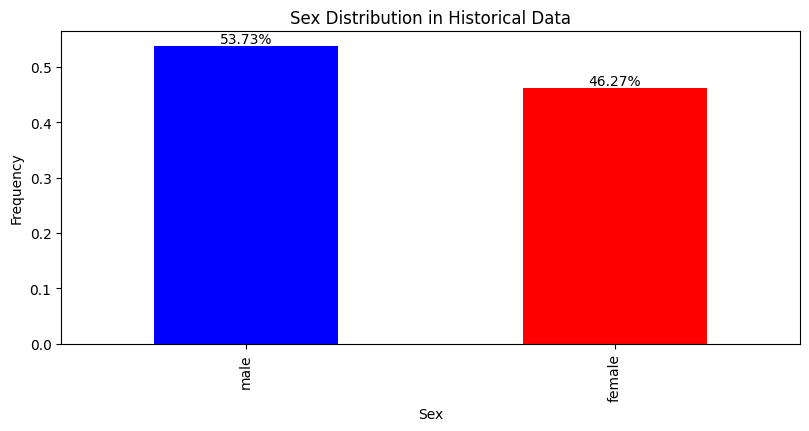

In [26]:
# Sex Distribution. 
ax = (name_sex_freq_df[["male", "female"]].sum() / name_sex_freq_df["count"].sum()).plot(kind='bar', color=['blue', 'red'], figsize=(8, 4))

def annotate_bar(ax, xlabel, ylabel, title):
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height()*100:.2f}%', 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 5), textcoords='offset points'
        )

    plt.tight_layout()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


annotate_bar(ax=ax, xlabel="Sex", ylabel="Frequency", title="Sex Distribution in Historical Data")


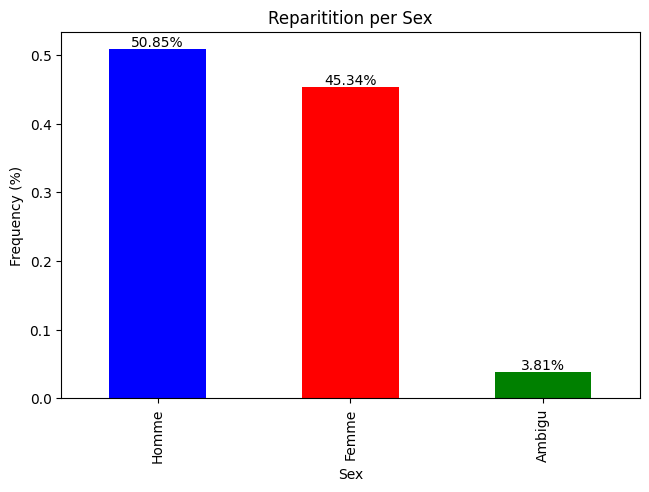

In [88]:
ax = (sex_gt_df["sex"].value_counts(normalize=True).plot(kind="bar", color=["blue", "red", "green"]))
annotate_bar(ax=ax, xlabel="Sex", ylabel="Frequency (%)", title="Reparitition per Sex")

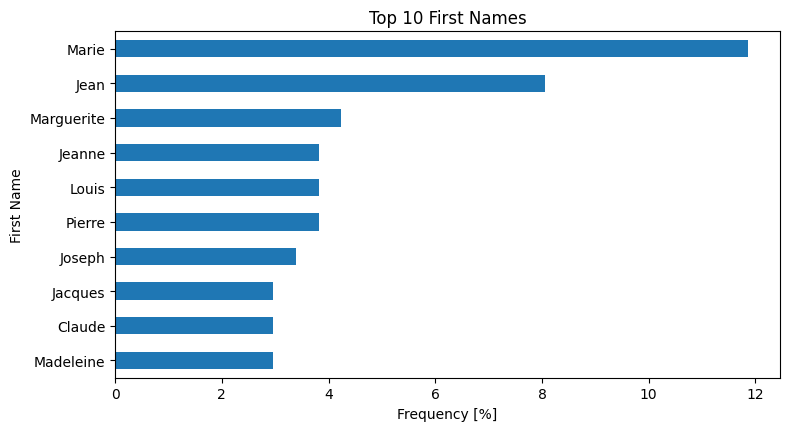

In [27]:
ax = (
    sex_gt_df['firstname_gt']
    .value_counts(normalize=True)
    .head(10)
    .sort_values() * 100
    ).plot(kind="barh", figsize=(8, 4))

# Add text to the plot.
plt.tight_layout()
plt.xlabel("Frequency [%]")
plt.ylabel("First Name")
plt.title("Top 10 First Names")
plt.show()

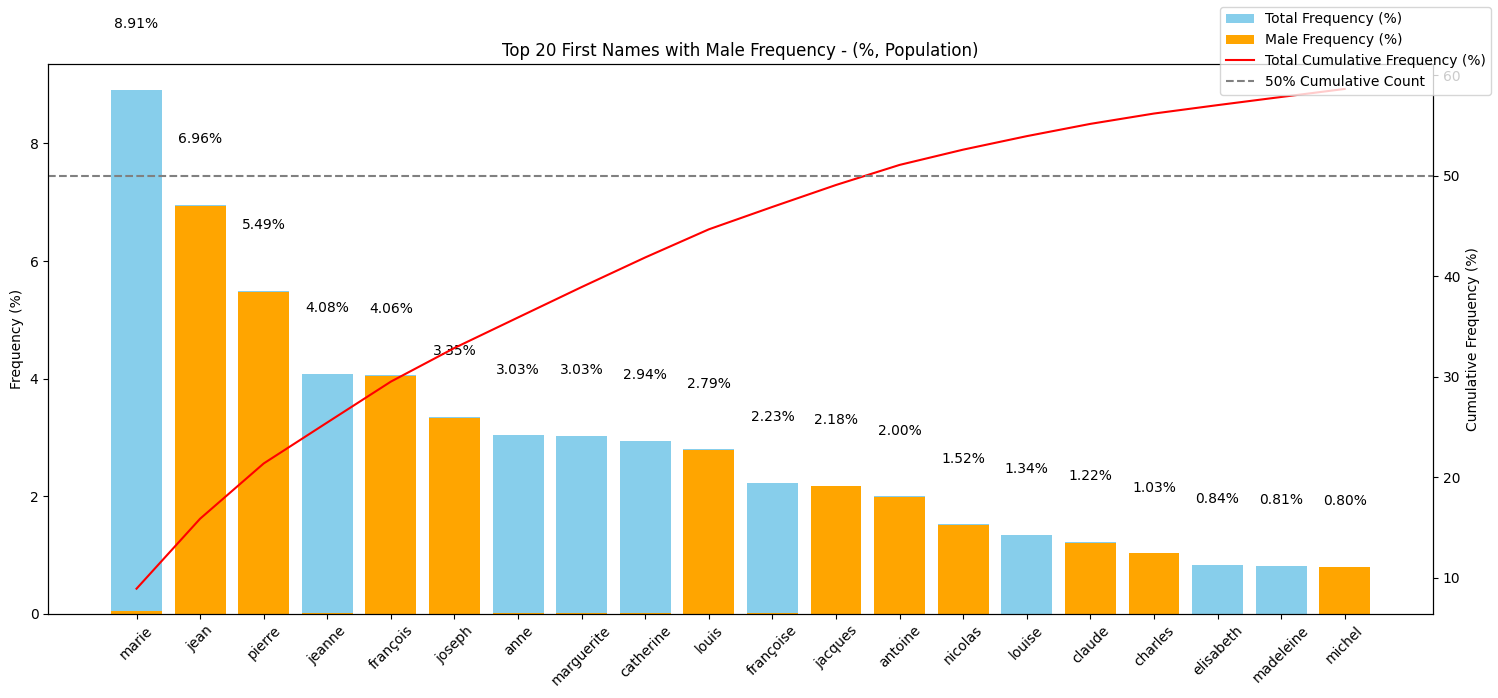

In [66]:
import matplotlib.pyplot as plt

# Calculate total count of all names
total_count = name_male_lk_df['count'].sum()

# Select top 15 names by count
top_names = name_male_lk_df.nlargest(20, 'count')

# Calculate male count and convert to percentage
top_names['male_count_pct'] = top_names['count'] * top_names['male_likelihood'] / total_count * 100

# Calculate count percentage
top_names['count_pct'] = top_names['count'] / total_count * 100

# Calculate cumulative count percentage
top_names['cumulative_count_pct'] = top_names['count_pct'].cumsum()

# Sort by count for better visualization
top_names = top_names.sort_values('count_pct', ascending=False)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(top_names['firstname'], top_names['count_pct'], color='skyblue', label='Total Frequency (%)')

# Adding labels for male frequency above the bars
for i, v in enumerate(top_names['count_pct']):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

ax.bar(top_names['firstname'], top_names['male_count_pct'], color='orange', label='Male Frequency (%)')
plt.ylabel("Frequency (%)")

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Add cumulative count to the plot as a line plot on the secondary y-axis
ax2 = ax.twinx()
ax2.plot(top_names['firstname'], top_names['cumulative_count_pct'], color='red', label='Total Cumulative Frequency (%)')
ax2.axhline(y=50, color='gray', linestyle='--', label='50% Cumulative Count')

ax2.set_ylabel('Cumulative Frequency (%)')

# Add text to the plot
plt.tight_layout()
plt.xlabel("First Name")
plt.ylabel("Cumulative Frequency (%)")
plt.title("Top 20 First Names with Male Frequency - (%, Population)")
fig.legend(loc="upper right")
plt.show()


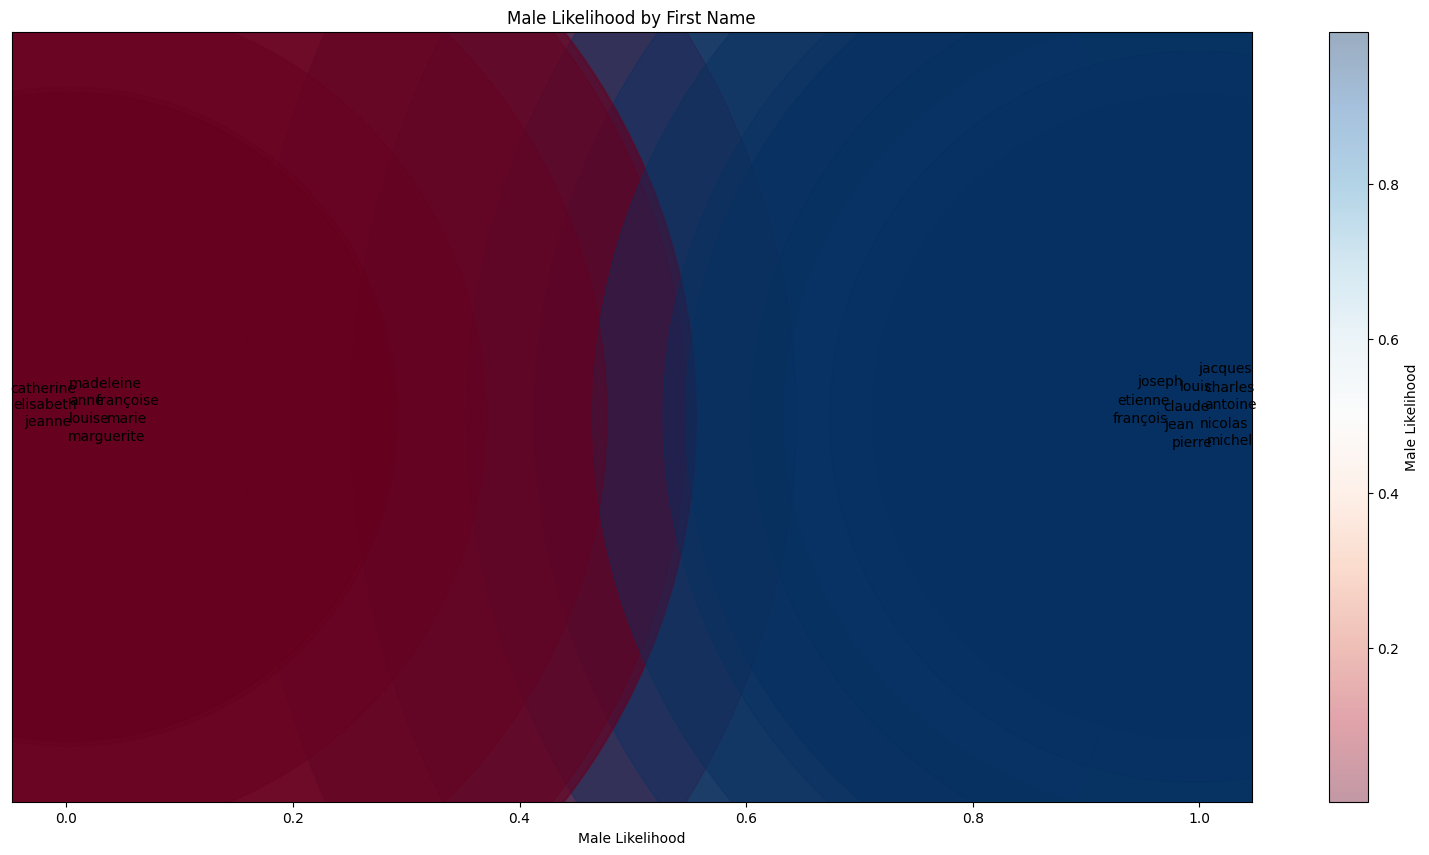

<Figure size 640x480 with 0 Axes>

In [29]:
from adjustText import adjust_text


df = name_male_lk_df[name_male_lk_df['count'] > 200_000]

# Create a scatter plot with 'male_likelihood' on the x-axis and zeros on the y-axis for alignment
fig, ax = plt.subplots(figsize=(20, 10))  # Set the figsize to a large size

scatter = ax.scatter(df['male_likelihood'], [0]*len(df), c=df['male_likelihood'], 
                     cmap='RdBu', s=df['count'], alpha=0.4)

# Add first names as text labels at their corresponding points
texts = []
for i in range(len(df)):
    texts.append(ax.text(df['male_likelihood'].iloc[i], 0, df['firstname'].iloc[i], 
                         horizontalalignment='center', verticalalignment='center', fontsize=10))

# Adjust the text labels to avoid overlapping
adjust_text(texts)

# Hide the y-axis
ax.axes.get_yaxis().set_visible(False)

# Add a colorbar
plt.colorbar(scatter, label='Male Likelihood')

# Set the title and x-axis label
ax.set_title('Male Likelihood by First Name')
ax.set_xlabel('Male Likelihood')

# Show the plot
plt.show()
plt.tight_layout()


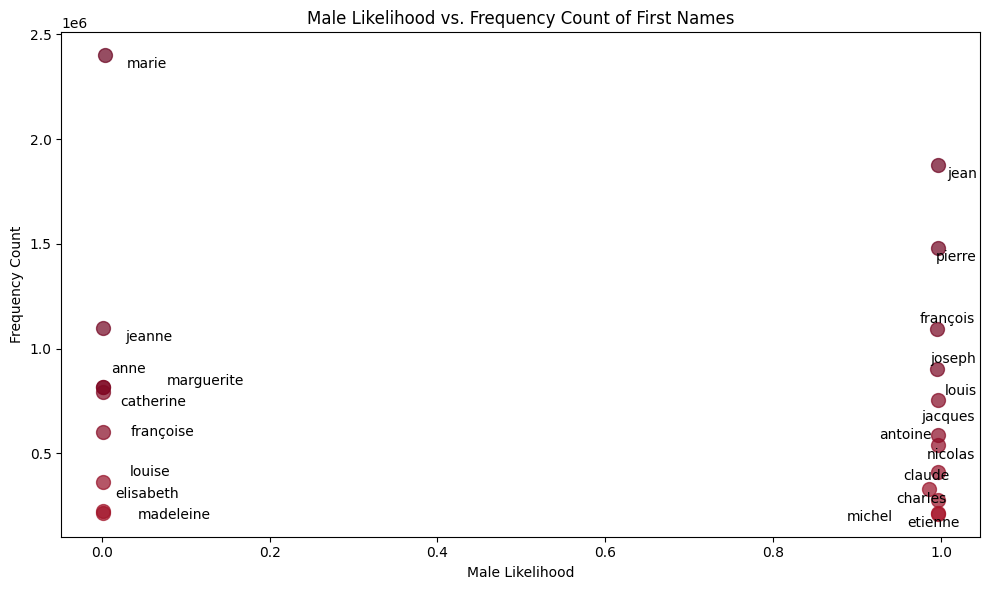

In [30]:
# Import the library
from adjustText import adjust_text

# Define color gradient
color_palette = sns.color_palette("RdBu", n_colors=len(sex_gt_df))

df = name_male_lk_df[name_male_lk_df['count'] > 200_000]
firstname_col = "firstname"

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot circles
texts = []  # List to store text objects
for i, row in df.iterrows():
    ax1.scatter(row["male_likelihood"], row["count"], s=100, color=color_palette[i], alpha=0.7)
    texts.append(ax1.text(row["male_likelihood"] + 0.02, row["count"], row[firstname_col], va='center'))

# Use adjust_text to avoid text overlapping
adjust_text(texts)


# Set labels and title
plt.xlabel("Male Likelihood")
plt.ylabel("Frequency Count")
plt.title("Male Likelihood vs. Frequency Count of First Names")

# Show plot
plt.tight_layout()
plt.show()

C:\Users\Yedidia AGNIMO\AppData\Local\Temp\ipykernel_6864\3743193957.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_count'] = np.log(df['count']) * 10
C:\Users\Yedidia AGNIMO\AppData\Local\Temp\ipykernel_6864\3743193957.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['boxcox_count'], _ = boxcox(df['count'])


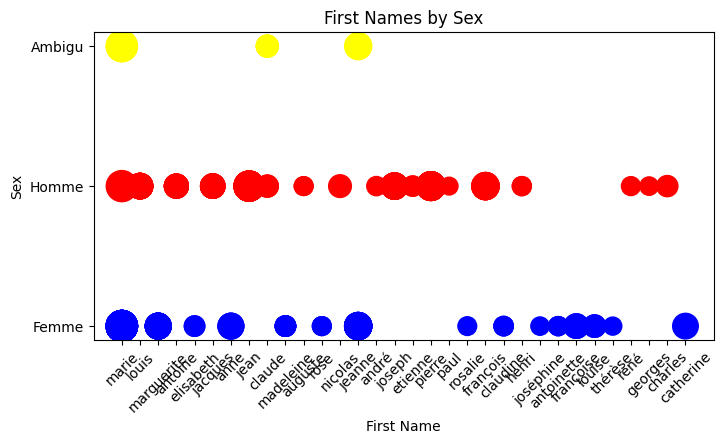

In [31]:
from scipy.stats import boxcox

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

df = sex_gt_df[sex_gt_df['count'] > 100_000]
df.reset_index(inplace=True)

# Create a log variable
df['log_count'] = np.log(df['count']) * 10
df['boxcox_count'], _ = boxcox(df['count'])

# Create a color map for the sex
colors = {'Femme': 'blue', 'Homme': 'red', 'Ambigu': 'yellow'}

# Plot each first name
# for i in range(len(df['firstname'])):
#     ax.scatter(df['firstname'][i], df['sex'][i], color=colors[df['sex'][i]], s=df['log_count'][i])

# Create a color map based on the 'sex' column
color_map = df['sex'].map(colors)

# Plot the data
ax.scatter(df['firstname'], df['sex'], c=color_map, s=df['boxcox_count'])

# Set the x-axis label
ax.set_xlabel("First Name")

# Set the y-axis label
ax.set_ylabel("Sex")

# Set the title
ax.set_title("First Names by Sex")

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Show the plot
plt.show()

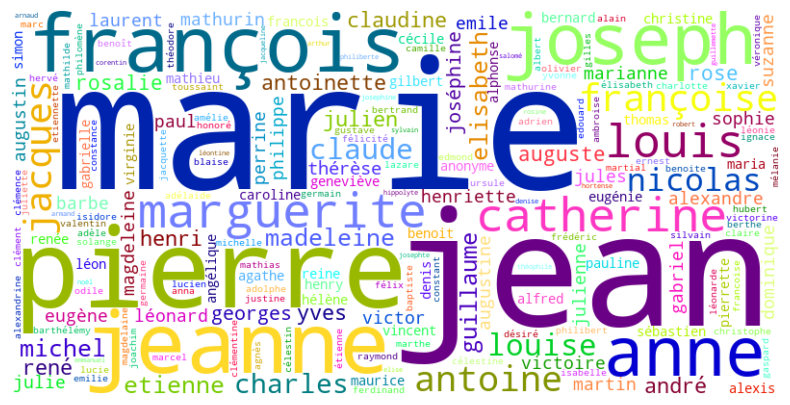

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary of first names and their corresponding counts
name_counts = dict(zip(name_male_lk_df['firstname'], name_male_lk_df['count']))

# Define color function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word == 'homme':
        return f"hsl({np.random.randint(200, 260)}, 100%, {np.random.randint(50, 75)}%)"  # Blue gradient for 'homme'
    elif word == 'femme':
        return f"hsl({np.random.randint(0, 20)}, 100%, {np.random.randint(50, 75)}%)"   # Red gradient for 'femme'
    else:
        return f"hsl({np.random.randint(0, 360)}, 100%, {np.random.randint(25, 75)}%)"   # Random color for other words

# Generate the word cloud with weighted counts
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(name_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


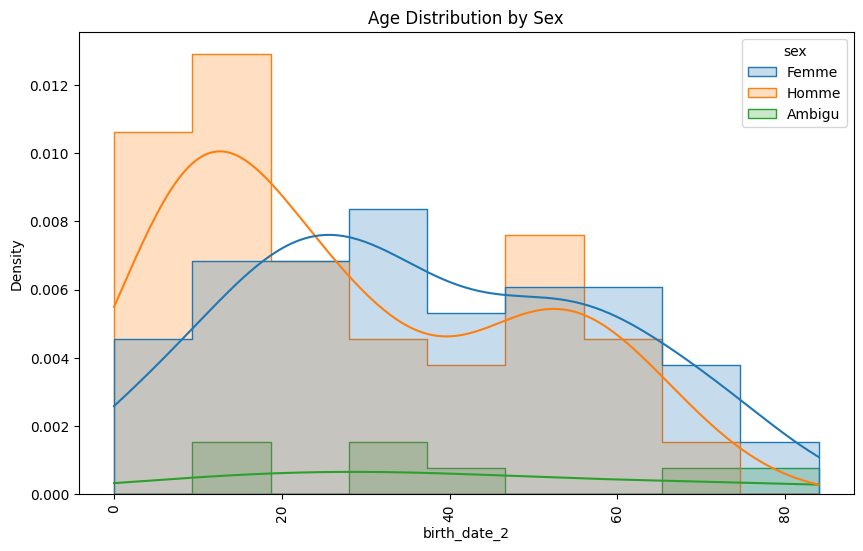

In [98]:
#
# df["birth_date_2"] = df["birth_date_2"].str.replace(r"[a-z]", "", regex=True).astype(int)
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df["birth_date_2"] < 1000], x='birth_date_2', hue='sex', element='step', stat='density', common_norm=True, kde=True)
plt.xticks(rotation=90)
plt.title('Age Distribution by Sex')
plt.show()

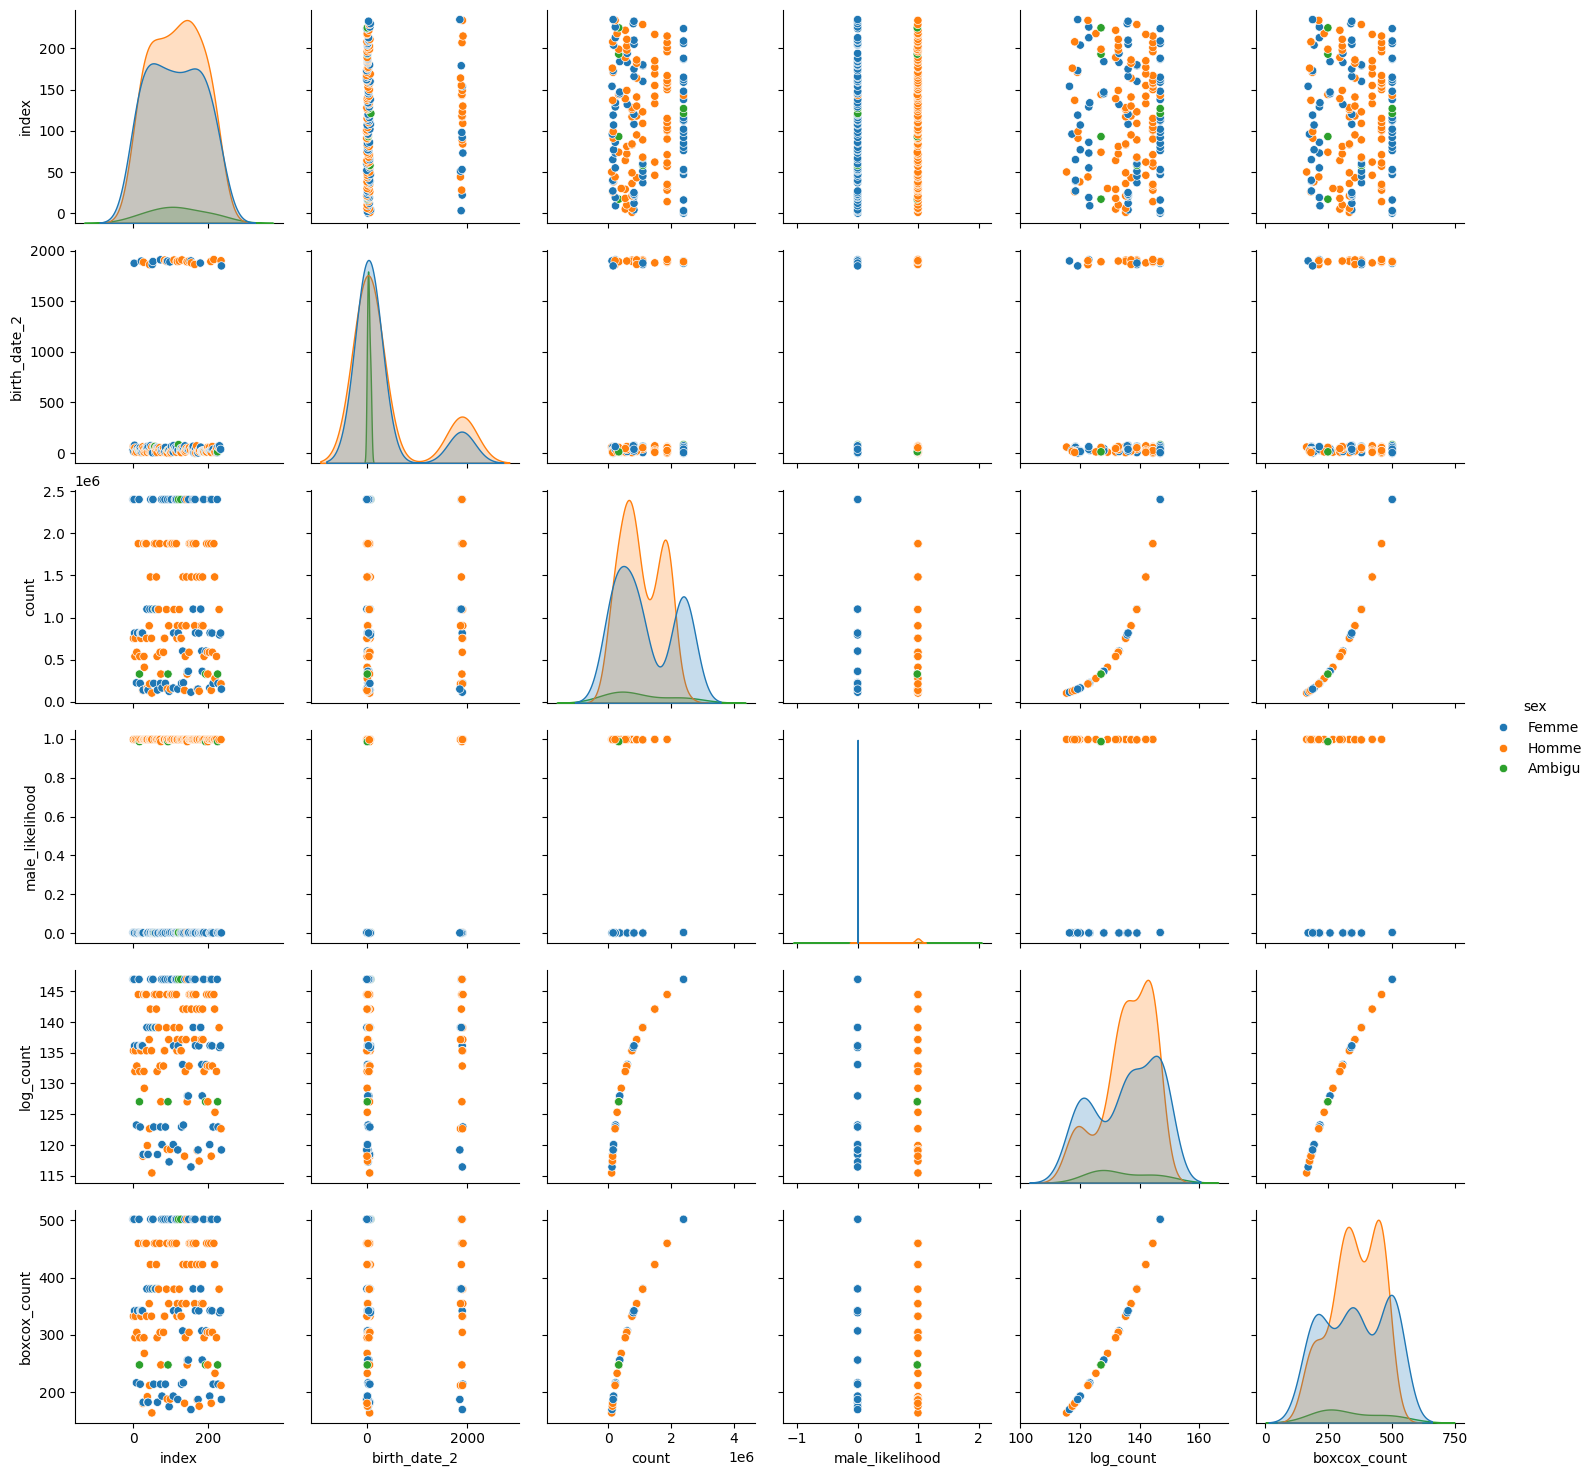

In [100]:
sns.pairplot(df, hue="sex")

## Modeling

### Features choice

In [33]:
sex_gt_df.columns

Index(['sex', 'surname_gt', 'firstname_gt', 'occupation_gt', 'link_gt',
       'age_gt', 'employer_gt', 'birth_date_gt', 'lob_gt', 'civil_status_gt',
       'observation_gt', 'firstname1_gt', 'firstname2_gt',
       'occupation_gt_normalized', 'link_gt_normalized', 'birth_date_2',
       'firstname', 'count', 'male_likelihood'],
      dtype='object')

In [34]:
features = [
    "firstname",
    "count",
    "male_likelihood",
    "occupation_gt_normalized",
    "link_gt_normalized",
    # "birth_date_2",
    # "lob_gt", 
]
target = "sex"
model_df = sex_gt_df[features+[target]]
model_df

,firstname,count,male_likelihood,occupation_gt_normalized,link_gt_normalized,sex
0,marie,2400467,0.004226,idem,enfant,Femme
1,louis,753218,0.996389,sans profession,chef,Homme
2,marie,2400467,0.004226,sans profession,chef,Femme
3,marie,2400467,0.004226,NaN,épouse,Femme
4,marguerite,815300,0.001767,NaN,NaN,Femme
...,...,...,...,...,...,...
231,pétronille,13097,0.002291,sans profession,épouse,Femme
232,alexandre,90651,0.995444,sans profession,enfant,Homme
233,marguerite,815300,0.001767,sans profession,épouse,Femme
234,etienne,212195,0.995768,NaN,enfant,Homme


In [35]:
model_df = model_df.map(lambda s: s.lower() if type(s) == str else s)
model_df.head()


,firstname,count,male_likelihood,occupation_gt_normalized,link_gt_normalized,sex
0,marie,2400467,0.004226,idem,enfant,femme
1,louis,753218,0.996389,sans profession,chef,homme
2,marie,2400467,0.004226,sans profession,chef,femme
3,marie,2400467,0.004226,NaN,épouse,femme
4,marguerite,815300,0.001767,NaN,NaN,femme


In [36]:
import numpy as np

# Define a function to replace 'ambigu' value
def replace_ambigu(row):
    return (row.loc["sex"] == "ambigu") * (
        (row.loc['male_likelihood'] > 0.5) * 'homme' 
        + (row.loc['male_likelihood'] < 0.5) * 'femme' 
        + (row.loc['male_likelihood'] == 0.5) * np.random.choice(['homme', 'femme'])
    ) + (row.loc["sex"] != "ambigu") * row.loc["sex"]
    # if row['sex'] == 'ambigu':
    #     if row['male_likelihood'] > 0.5:
    #         return 'homme'
    #     elif row['male_likelihood'] < 0.5:
    #         return 'femme'
    #     else:
    #         return np.random.choice(['homme', 'femme'])
    # else:
    #     return row['sex']



# Apply the function to the 'sex' column
model_df['sex'] = model_df.apply(replace_ambigu, axis=1)

# Binarize the 'sex' column
model_df['sex'] = model_df['sex'].map({'homme': 1, 'femme': 0})

In [37]:
model_df['sex'].value_counts(normalize=True)

sex
1    0.529661
0    0.470339
Name: proportion, dtype: float64

### Baseline

In [38]:
from sklearn.metrics import (
    accuracy_score,
    classification_report
)
from sklearn.model_selection import (
    RepeatedKFold,
    cross_val_score,
    cross_val_predict,
    train_test_split
)
from sklearn.dummy import DummyClassifier
from sklearn.utils.validation import check_is_fitted


In [39]:
SEED = 42
SCORING = "accuracy"
cv = RepeatedKFold(n_splits=5, random_state=SEED)

In [40]:
# Features-target, train-test splits.
X = model_df[features]
y = model_df[target]
 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print("X train shape", X_train.shape)
print("y train shape", y_train.shape)
print("X test shape", X_test.shape)
print("y test shape", y_test.shape)

X train shape (188, 5)
y train shape (188,)
X test shape (48, 5)
y test shape (48,)


In [41]:
def perform_cross_validation(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=cv):
    # Perform cross-validation on the training data
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=SCORING)
    
    # Print the mean and standard deviation of the training scores
    print(f"Training Accuracy: {scores.mean():.10f} (+/- {scores.std() * 2:.10f})")
    
    
    # Fit the model to the training data
    if not check_is_fitted(model):
        model.fit(X_train, y_train)
    

    print("--------------------------------------------")
    # Use the model to make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and print the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")
    
    # Generate and print the classification report
    report = classification_report(y_test, y_pred, zero_division=0.0)
    print("Classification Report:")
    print(report)

* **Estimating Uncertainty** using the frequency of sex conditional on a first name.

Let $lm_c \in [0, 1]$ represent the likelihood of being male given a first name $c$. The residual uncertainty, when using $lm_c$ as an estimator, is given by:
$$
min(1-lm_c, lm_c) = 1/2 - | 1/2 - lm_c |
$$

If a first name were a perfect predictor, capable of eliminating all uncertainty about sex, we would observe a unique sex associated with each name. In this case, the estimated likelihood would be either exactly 0 (for females) or 1 (for males). Any deviation from these values represents the proportion of individuals with this name who do not conform to the common trend.

In essence, this is equivalent to the regression function $\eta(X) = P[y = 1 | X]$, which is the conditional probability of the positive class given the features in a binary classification problem, where y is the target variable and X represents the features.

In [42]:
# Uncertainty estimation
(1/2 - np.abs(1/2 - model_df["male_likelihood"])).mean()

0.005723804212525448

* The implications for the model we are building are significant. Given that conditioning on the first name accounts for more than 99.995% of the variance on average, our model will need to perform at least as well as this to be considered effective. This sets a high bar for performance and will likely require careful feature engineering and model selection. However, it's important to note that these results are based on a small sample size. While the data providers claim that this sample is representative of the population, we should be cautious about overgeneralizing these results. The performance of our model on this sample may not accurately reflect its performance on a larger, more diverse population. 


In [43]:
# Create a dummy classifier
dummy = DummyClassifier(strategy='prior')
dummy_sample_weight_train = X_train["count"]

# Train the classifier
dummy.fit(X_train, y_train, sample_weight=dummy_sample_weight_train)

DummyClassifier()

In [44]:
perform_cross_validation(dummy)

Training Accuracy: 0.5225320057 (+/- 0.1767003685)
--------------------------------------------
Test Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.50      1.00      0.67        24

    accuracy                           0.50        48
   macro avg       0.25      0.50      0.33        48
weighted avg       0.25      0.50      0.33        48



### Modeling 1 - Prior Frequency

In [45]:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    TargetEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
) 

* **Prior Frequency Conditional to First Name / First Name Target Encoding As Predictor** As previously presented, the prior frequency model uses the proportion of males given a first name as an estimate for the probability of being male. This intuitive and straightforward estimator is based on the conditional empirical mean from past observations. This approach is also equivalent to target encoding, as discussed in Pargent et al. (2022). This encoding scheme is particularly useful for categorical features with high cardinality, where one-hot encoding would significantly inflate the feature space, making it more computationally expensive for a downstream model to process. Therefore, this encoding can and will serve as a preprocessing step in a larger pipeline for another model. It will be interesting to compare its performance with other competing preprocessing methods for the first name, which will be a main subject of discussion in the following sections.

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin

class PriorFrequency(BaseEstimator, ClassifierMixin):
    def __init__(self, prior='prior', threshold=0.5):
        self.prior = prior
        self.threshold = threshold
        self.fitted_ = False

    def fit(self, X, y=None):
        self.fitted_ = True
        self.classes_ = [0, 1]
        return self

    def predict(self, X):
        return (X[self.prior] > self.threshold).astype(int)


# Creating an instance of PriorModel
prior_model = PriorFrequency(prior='male_likelihood')

# Fitting the model (no fitting needed for this model)
prior_model.fit(X_train, y_train)

predicted_sex = prior_model.predict(X_test)

# print("Predicted sex:", predicted_sex[:5])

perform_cross_validation(prior_model)


Training Accuracy: 0.9946657183 (+/- 0.0213394973)
--------------------------------------------
Test Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



### Modeling 2 - "Standard" Machine Learning

In [47]:
# Missing values per sex.
model_df['occupation_gt_normalized'].isnull().groupby(model_df['sex']).agg('sum')

sex
0    22
1    24
Name: occupation_gt_normalized, dtype: int64

In [48]:
# Number of unique values / categories per column.
model_df.nunique()

firstname                   83
count                       83
male_likelihood             83
occupation_gt_normalized    47
link_gt_normalized          12
sex                          2
dtype: int64

In [51]:
model_df["link_gt_normalized"].value_counts()
model_df["occupation_gt_normalized"].value_counts()

occupation_gt_normalized
sans profession            75
cultivateur                25
domestique                 18
métayer                     7
receveur enregistrement     5
manoeuvre                   4
domestique de ferme         3
journalier                  3
employé                     2
couvreur                    2
garde part                  2
tisserand                   2
forgeron                    2
imprimeur                   2
propriétaire                2
charcutier                  2
jardinier                   2
agent de police             2
argentière                  2
rentière                    1
garde particultivateur      1
repasseuse                  1
idem                        1
ouvrier meunier             1
tourneur                    1
couturière                  1
journalier terrassier       1
déposit de journaux         1
employée                    1
coiffeur                    1
charretier                  1
clerc de nptaire            1
nourrisson     

* We will employ a standard machine learning model to potentially uncover more patterns by integrating numerous features. At this point, the data has already been divided into training and testing sets. The remaining steps primarily involve constructing a pipeline with preprocessing stages and an estimator, tuning hyperparameters via cross-validation with respect to the chosen metrics (accuracy), and then making and evaluating predictions on both the training and testing sets. We will report the standard deviation during the cross-validation to provide an indication of stability. Ideally, if time permits, we would repeat the experiment, altering the seed each time during the train-test split to examine how the split impacts the results (a stability check). 
  
* Our primary focus will be on the preprocessing steps before training the model, specifically handling missing values and encoding categorical variables. It's important to remember that the results are heavily dependent on the quality of the extracted data (which we assume to be reliable to a certain extent) and on how the column categories have been normalized (for example, different spellings). This is crucial as the records originate from a wide variety of collectors over different time periods. 
  
  * The data cleaning phase was performed manually in this instance. However, we could have utilized a language model, such as Fast Text, which could have been beneficial for modeling skip-grams while considering subwords to decipher similarities and suggest associations. Alternatively, a simple edit distance check could have been used to identify potential misspellings. A potential pipeline could involve inferring from abbreviations, addressing misspellings, and then performing lemmatization to eliminate gender declensions. This would return an arbitrarily chosen normalized form for each category (one might choose one gender as the default). Well, we should be carefull as by lemmatizing we would loose crucial information about the sex as precisely the gender declination would help greatly in the prediction.
   
  * Regarding missing values, it's likely that the 'occupation' field is predominantly filled with unemployed individuals. We would appreciate more details about the data collection process, including information about the collectors, any challenges encountered, and the conditions under which the data was gathered. For the "link" column, as discuss previously, knowing the household head could help with in determining the ordering of observation then used to completed "idem" line (that still remain to be filled). This missing values could be predicted based on the other observation. For example, one might think predictig the occupation with mostly the company (but there also a lot of misisng), the sex (as data are from 1836 - 1936, gender role where even more proeminent and then the occupation patterns, region). Global statstics on the repartition of occupation per gender and occupation. Another treatment would be to use a pre-trained language model and make inference with it. 
  
  * Handling high-cardinality categorical features can be challenging, especially when dealing with a large number of unique categories. The conventional approach of One-Hot-Encoding, which creates a binary variable for each category, significantly increases dimensionality and thus complicates the model. This complexity can hinder effective learning, especially in cases like ours where the dataset is relatively small (243 observations). || In such situations, grouping categories into broader categories may be a more prudent approach, particularly when fine-grained details are not crucial for prediction accuracy. For instance, consider the predictive power of occupation in determining gender during the 19th-20th centuries. While certain professions may be more strongly associated with one gender over another, it is often the general type of profession rather than its specific details that matter. For example, categorizing occupations into broader groups like "Craftsmanship" could provide sufficient information, rather than listing specific professions such as baker, blacksmith, or weaver. || Another alternative is ordinal encoding, where each category is assigned an arbitrary numerical value. However, a drawback of this method is that it imposes an arbitrary ordering among the categories, unlike One-Hot-Encoding, which treats each category independently. This can distort the reality, especially for nominal variables like occupation or links. ||Alternatively, utilizing embeddings from a pretrained foundational model (or one specifically trained on a task similar to gender prediction) could be beneficial. This approach leverages learned representations of the categorical variables, potentially capturing nuanced relationships between categories while mitigating dimensionality concerns.

* We will employ straightforward algorithms such as Logistic Regression, Random Forest, and Histogram Gradient Boosting. On one hand, we are dealing exclusively with categorical features, with birth date/age being difficult to utilize. On the other hand, we believe that if certain features significantly contribute to predicting sex, simple decision rules should suffice to identify a strong predictor. Furthermore, if a decision rule proves to be an excellent predictor, a decision tree or a random forest would likely discover it.

make column selector, make column transformer, build pipeline, 
replace nan with "sans profession" in "occupation_gt_normalized", and nan with "manquant" in "link_gt_normalized" 


### Modeling 3 - Foundation models and transfer learning